This code uses the skipgram model to create word2vec encodings and then use those encodings to represent the input words to our model.

In [83]:
import numpy as np
import pandas as pd

from tensorflow import one_hot
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import text, sequence
from tensorflow import cast
from tensorflow import float32

import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

import matplotlib.pyplot as plt

In [27]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100

EMBEDDING_DIM=100

In [215]:
train=pd.read_csv("./jigsaw-toxic-comment-classification-challenge/train.csv.zip")

In [216]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;\n]')
BAD_SYMBOLS_RE = re.compile('[^a-z ]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

def correction(text):
    return str(TextBlob(text).correct())
#train['comment_text']= train['comment_text'].apply(correction)
train['comment_text'] = train['comment_text'].apply(clean_text)

In [217]:
tokenizer = text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train["comment_text"].values)

In [218]:
X = tokenizer.texts_to_sequences(train["comment_text"].values)
X = sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [219]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].to_numpy()

In [220]:
word2vec_model = keras.Sequential()
word2vec_model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=1,mask_zero=True))
word2vec_model.add(layers.Dense(MAX_NB_WORDS,activation='softmax'))

word2vec_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam')

word2vec_model.summary()

word2vec_model.load_weights("word2vec.model")


Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 1, 100)            1000000   
_________________________________________________________________
dense_83 (Dense)             (None, 1, 10000)          1010000   
Total params: 2,010,000
Trainable params: 2,010,000
Non-trainable params: 0
_________________________________________________________________


In [221]:
del train

In [222]:
weights=1/(2*y.mean(0))
neg_weights=1/(2*(1-y.mean(0)))

def lossy(y_true,y_pred):
    y_true=cast(y_true, float32)
    loss = 0
    loss -= (weights[0]*y_true[0]*K.log(y_pred[0]+1e-5) + neg_weights[0]*(1-y_true[0])*K.log(1-y_pred[0]+1e-5))
    loss -= (weights[1]*y_true[1]*K.log(y_pred[1]+1e-5) + neg_weights[1]*(1-y_true[1])*K.log(1-y_pred[1]+1e-5))
    loss -= (weights[2]*y_true[2]*K.log(y_pred[2]+1e-5) + neg_weights[2]*(1-y_true[2])*K.log(1-y_pred[2]+1e-5))
    loss -= (weights[3]*y_true[3]*K.log(y_pred[3]+1e-5) + neg_weights[3]*(1-y_true[3])*K.log(1-y_pred[3]+1e-5))
    loss -= (weights[4]*y_true[4]*K.log(y_pred[4]+1e-5) + neg_weights[4]*(1-y_true[4])*K.log(1-y_pred[4]+1e-5))
    loss -= (weights[5]*y_true[5]*K.log(y_pred[5]+1e-5) + neg_weights[5]*(1-y_true[5])*K.log(1-y_pred[5]+1e-5))
    return loss

In [223]:
epochs = 10
batch_size = 128

In [224]:
cnn_model = keras.Sequential()
cnn_model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM,weights=word2vec_model.layers[0].get_weights(),
           input_length=MAX_SEQUENCE_LENGTH,trainable=False))
cnn_model.add(layers.Conv1D(128, 9, activation='relu', padding='same'))
cnn_model.add(layers.MaxPooling1D(2))
cnn_model.add(layers.Conv1D(64, 7,activation='relu', padding='same'))
cnn_model.add(layers.GlobalMaxPooling1D())
cnn_model.add(layers.Dropout(0.2))
cnn_model.add(layers.Dense(32, activation='relu'))
cnn_model.add(layers.Dense(16, activation='relu'))
cnn_model.add(layers.Dense(6, activation='sigmoid'))
cnn_model.compile(loss=lossy, optimizer='adam', metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.AUC(multi_label=True)])
#'binary_crossentropy'

In [225]:
cnn_model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 100, 128)          115328    
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 50, 128)           0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 50, 64)            57408     
_________________________________________________________________
global_max_pooling1d_27 (Glo (None, 64)                0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_84 (Dense)             (None, 32)              

In [226]:
history = cnn_model.fit(X, y, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
1122/1122 [==============================] - 74s 65ms/step - loss: 6.8214 - binary_accuracy: 0.6100 - auc_28: 0.7158 - val_loss: 2.5672 - val_binary_accuracy: 0.7523 - val_auc_28: 0.9410
Epoch 2/10
1122/1122 [==============================] - 71s 63ms/step - loss: 3.1760 - binary_accuracy: 0.7816 - auc_28: 0.9307 - val_loss: 2.8762 - val_binary_accuracy: 0.7221 - val_auc_28: 0.9476
Epoch 3/10
1122/1122 [==============================] - 72s 64ms/step - loss: 3.3030 - binary_accuracy: 0.7380 - auc_28: 0.9355 - val_loss: 1.9939 - val_binary_accuracy: 0.8496 - val_auc_28: 0.9511
Epoch 4/10
1122/1122 [==============================] - 72s 64ms/step - loss: 2.3979 - binary_accuracy: 0.8306 - auc_28: 0.9482 - val_loss: 2.7586 - val_binary_accuracy: 0.6781 - val_auc_28: 0.9406
Epoch 5/10
1122/1122 [==============================] - 70s 62ms/step - loss: 3.3644 - binary_accuracy: 0.7434 - auc_28: 0.9422 - val_loss: 1.9183 - val_binary_accuracy: 0.8124 - val_auc_28: 0.9583
Epoch 6/10

KeyboardInterrupt: 

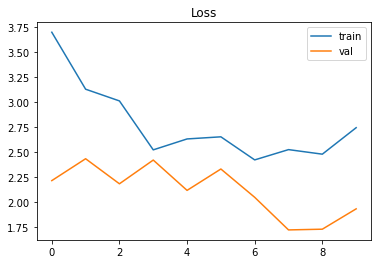

In [191]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show();

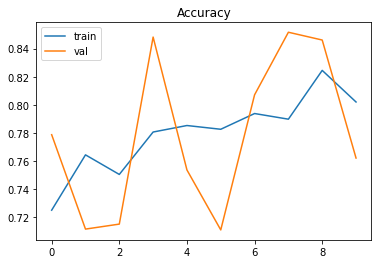

In [192]:
plt.title('Accuracy')
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='val')
plt.legend()
plt.show();

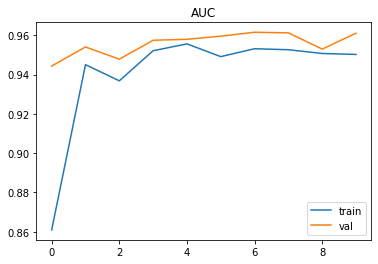

In [193]:
plt.title('AUC')
plt.plot(history.history['auc_25'], label='train')
plt.plot(history.history['val_auc_25'], label='val')
plt.legend()
plt.show();

In [194]:
cnn_model.layers[0].trainable=True

In [195]:
Second_epochs=5
lr=0.00001
opt = keras.optimizers.Adam(learning_rate=lr)
cnn_model.compile(loss=lossy, optimizer=opt, metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.AUC(multi_label=True)])
history = cnn_model.fit(X, y, epochs=Second_epochs, batch_size=batch_size,validation_split=0.1,callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
1122/1122 [==============================] - 59s 52ms/step - loss: 3.5346 - binary_accuracy: 0.7730 - auc_26: 0.9575 - val_loss: 1.9035 - val_binary_accuracy: 0.7751 - val_auc_26: 0.9613
Epoch 2/5
1122/1122 [==============================] - 52s 47ms/step - loss: 2.0022 - binary_accuracy: 0.7850 - auc_26: 0.9591 - val_loss: 1.8582 - val_binary_accuracy: 0.7917 - val_auc_26: 0.9616
Epoch 3/5
1122/1122 [==============================] - 50s 44ms/step - loss: 1.8843 - binary_accuracy: 0.7985 - auc_26: 0.9589 - val_loss: 1.8128 - val_binary_accuracy: 0.8045 - val_auc_26: 0.9619
Epoch 4/5
1122/1122 [==============================] - 49s 44ms/step - loss: 3.1484 - binary_accuracy: 0.8065 - auc_26: 0.9583 - val_loss: 1.8083 - val_binary_accuracy: 0.8055 - val_auc_26: 0.9620
Epoch 5/5
1122/1122 [==============================] - 56s 50ms/step - loss: 2.5863 - binary_accuracy: 0.8065 - auc_26: 0.9618 - val_loss: 1.8172 - val_binary_accuracy: 0.8006 - val_auc_26: 0.9620


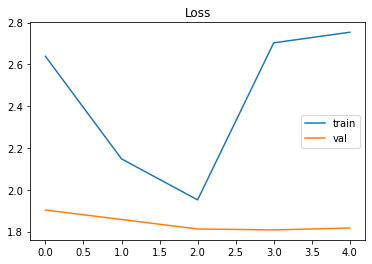

In [196]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show();

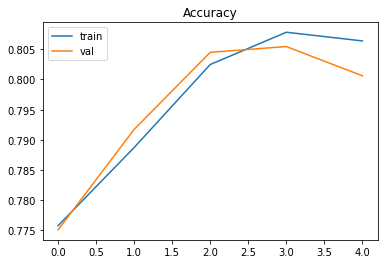

In [197]:
plt.title('Accuracy')
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='val')
plt.legend()
plt.show();

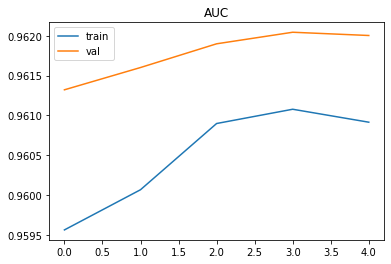

In [199]:
plt.title('AUC')
plt.plot(history.history['auc_26'], label='train')
plt.plot(history.history['val_auc_26'], label='val')
plt.legend()
plt.show();

In [200]:
del X
del y

In [201]:
test=pd.read_csv("./jigsaw-toxic-comment-classification-challenge/test.csv.zip")
test_lab = pd.read_csv("./jigsaw-toxic-comment-classification-challenge/test_labels.csv")

In [202]:
df_test = test.merge(test_lab, on = 'id')
df_test = df_test[df_test['toxic'] != -1]
y_test = df_test[list_classes].to_numpy()

In [203]:
df_test['comment_text'] = df_test['comment_text'].apply(clean_text)
X_test = tokenizer.texts_to_sequences(df_test["comment_text"].values)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

In [204]:
cnn_model.evaluate(X_test,y_test)

2000/2000 [==============================] - 6s 3ms/step - loss: 2.5775 - binary_accuracy: 0.7362 - auc_26: 0.9529


[2.5774877071380615, 0.7361770868301392, 0.9528511166572571]

In [205]:
cnn_model.save_weights("cnnmodel")

In [209]:
new_insult = ['good']
new_insult[0] = clean_text(new_insult[0])
seq = tokenizer.texts_to_sequences(new_insult)
padded = sequence.pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = cnn_model.predict(padded)
pred

array([[0.5511313 , 0.05325899, 0.39269385, 0.0845041 , 0.4731392 ,
        0.20840496]], dtype=float32)